# **Written by Deepak Yadav**

### **Image Classification Using Pre-train VGG - 16 Using Transfer Learning and Fine Tuning** 

The difference between Transfer Learning and Fine-Tuning is that 

* In Transfer Learning, we only optimize the weights of the new classification layers we have added, while we keep the weights of the original VGG16 model. 

* In Fine-Tuning we optimize both the weights of the new classification layers we have added, as well as some or all of the layers from the VGG16 model.

# **Transfer Learning Architecture**

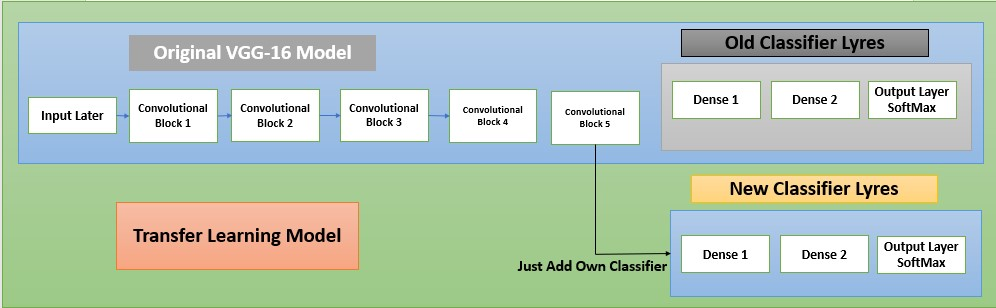

# **Fine Tuning Architecture**

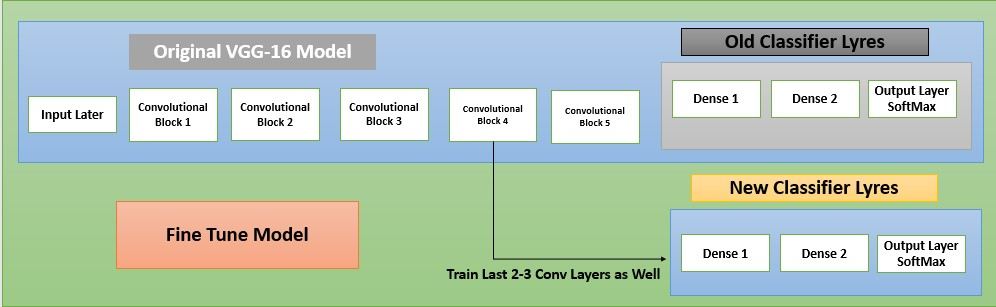

In [8]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
import cv2
import sklearn 
import tensorflow as tf
from tensorflow import keras
from PIL import Image as im
from glob import glob
from sklearn.model_selection import train_test_split
import keras
#from tf.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from PIL import Image as im
import cv2

In [10]:
# Set seeds to make the experiment more reproducible.
import random
def seed_everything(seed = 0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed = 0
seed_everything(seed)

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
BATCH_SIZE = 64
img_height = 244
img_width = 244

# **Load Datasets**

In [4]:
import os
data_path = '/project/code/deepak/Pytorch_Tutorial/data_smu2'
os.listdir(data_path)

['train', 'test', 'val']

In [173]:
input_path = data_path
train_data_dir = input_path + '/' + 'train/'
test_data_dir = input_path + '/' + 'test/'
val_data_dir = input_path + '/' + 'val/'

In [113]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = BATCH_SIZE,
    seed = 123)

Found 2548 files belonging to 3 classes.


In [16]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_data_dir,
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = BATCH_SIZE,
    seed = 123)

Found 326 files belonging to 3 classes.


In [180]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = BATCH_SIZE,
    shuffle = False,
    seed = 123)

Found 300 files belonging to 3 classes.


In [114]:
class_names = train_ds.class_names
print(class_names)

['cats', 'dogs', 'panda']


# **DataSets Visualizations**

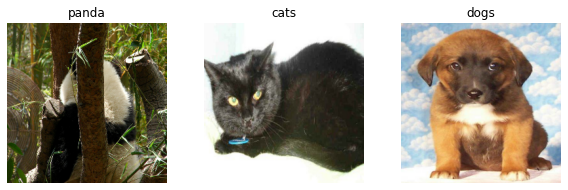

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(len(class_names)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

In [20]:
data_augmentation = keras.Sequential([
    #layers.CenterCrop(125, 125),
    layers.RandomFlip('horizontal', input_shape = (img_height, img_width, 3)),
    layers.RandomRotation(0.2, fill_mode = 'nearest'),
    layers.RandomZoom(0.1),
])

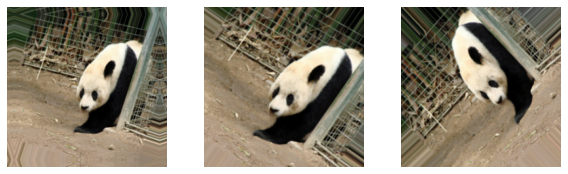

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(len(class_names)):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
   # plt.title(class_names[2])
    plt.axis("off")

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

# **Model Architecture** 

*   **VGG-16 Base Model**







In [65]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (img_height, img_width, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                         include_top = False,
                                         weights = 'imagenet')
#base_model.trainable = False
base_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 244, 244, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 122, 122, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 122, 122, 32  128         ['Conv1[0][0]']                  
                

In [66]:
def print_layer_trainable():
    for layer in base_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [67]:
print_layer_trainable()

True:	input_3
True:	Conv1
True:	bn_Conv1
True:	Conv1_relu
True:	expanded_conv_depthwise
True:	expanded_conv_depthwise_BN
True:	expanded_conv_depthwise_relu
True:	expanded_conv_project
True:	expanded_conv_project_BN
True:	block_1_expand
True:	block_1_expand_BN
True:	block_1_expand_relu
True:	block_1_pad
True:	block_1_depthwise
True:	block_1_depthwise_BN
True:	block_1_depthwise_relu
True:	block_1_project
True:	block_1_project_BN
True:	block_2_expand
True:	block_2_expand_BN
True:	block_2_expand_relu
True:	block_2_depthwise
True:	block_2_depthwise_BN
True:	block_2_depthwise_relu
True:	block_2_project
True:	block_2_project_BN
True:	block_2_add
True:	block_3_expand
True:	block_3_expand_BN
True:	block_3_expand_relu
True:	block_3_pad
True:	block_3_depthwise
True:	block_3_depthwise_BN
True:	block_3_depthwise_relu
True:	block_3_project
True:	block_3_project_BN
True:	block_4_expand
True:	block_4_expand_BN
True:	block_4_expand_relu
True:	block_4_depthwise
True:	block_4_depthwise_BN
True:	block_4_d

**Fix the weights**

In [68]:
base_model.trainable = False

In [69]:
for layer in base_model.layers:
    layer.trainable = False

In [70]:
print_layer_trainable()

False:	input_3
False:	Conv1
False:	bn_Conv1
False:	Conv1_relu
False:	expanded_conv_depthwise
False:	expanded_conv_depthwise_BN
False:	expanded_conv_depthwise_relu
False:	expanded_conv_project
False:	expanded_conv_project_BN
False:	block_1_expand
False:	block_1_expand_BN
False:	block_1_expand_relu
False:	block_1_pad
False:	block_1_depthwise
False:	block_1_depthwise_BN
False:	block_1_depthwise_relu
False:	block_1_project
False:	block_1_project_BN
False:	block_2_expand
False:	block_2_expand_BN
False:	block_2_expand_relu
False:	block_2_depthwise
False:	block_2_depthwise_BN
False:	block_2_depthwise_relu
False:	block_2_project
False:	block_2_project_BN
False:	block_2_add
False:	block_3_expand
False:	block_3_expand_BN
False:	block_3_expand_relu
False:	block_3_pad
False:	block_3_depthwise
False:	block_3_depthwise_BN
False:	block_3_depthwise_relu
False:	block_3_project
False:	block_3_project_BN
False:	block_4_expand
False:	block_4_expand_BN
False:	block_4_expand_relu
False:	block_4_depthwise
Fa

In [71]:
n_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation = 'softmax')
])

### **Transfer Learning**







In [72]:
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 244, 244, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 244, 244, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 128)               163968    
                                                                 
 dropout_3 (Dropout)         (None, 128)              

In [73]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [74]:
# Model Chackpoint
tl_checkpoint_1 = ModelCheckpoint(filepath = 'vgg16_best_weights.hdf5', save_best_only = True, verbose = 0)

# EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True, mode = 'min')

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.000001)

In [75]:
%%time
history = model.fit(train_ds,
                    epochs = 20,
                    validation_data = val_ds,
                    callbacks = [tl_checkpoint_1, early_stop, rop_callback])

Epoch 1/20
40/40 [==============================] - 9s 97ms/step - loss: 0.3382 - accuracy: 0.8630 - val_loss: 0.0508 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 2/20
40/40 [==============================] - 2s 54ms/step - loss: 0.1371 - accuracy: 0.9466 - val_loss: 0.0469 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 3/20
40/40 [==============================] - 2s 54ms/step - loss: 0.1140 - accuracy: 0.9537 - val_loss: 0.0455 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 4/20
40/40 [==============================] - 2s 43ms/step - loss: 0.1316 - accuracy: 0.9553 - val_loss: 0.0483 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 5/20
40/40 [==============================] - 2s 43ms/step - loss: 0.1057 - accuracy: 0.9600 - val_loss: 0.0478 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 6/20
40/40 [==============================] - 2s 54ms/step - loss: 0.0850 - accuracy: 0.9694 - val_loss: 0.0355 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 7/20
40/40 [==============================] - 2s 42ms/step - loss: 0.0

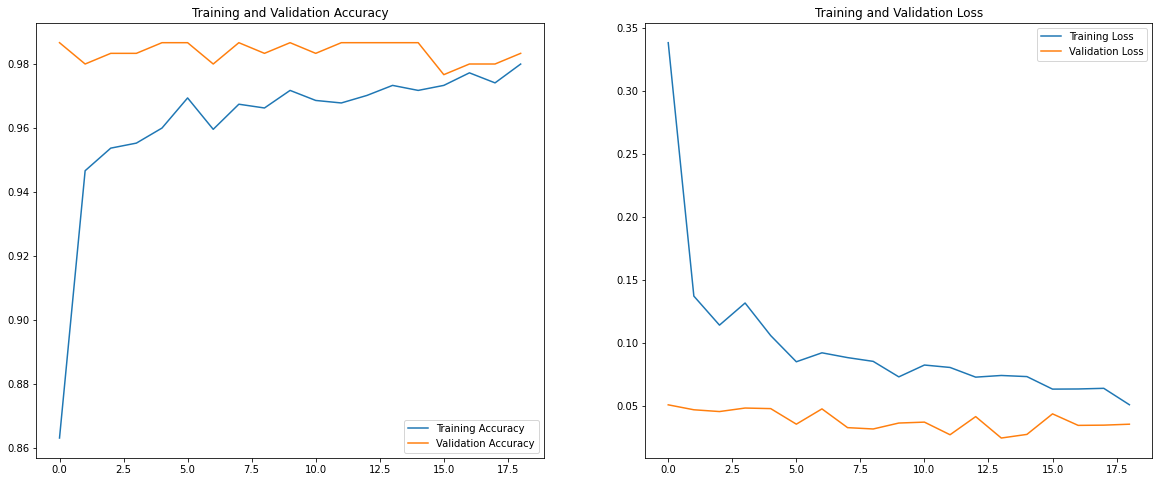

In [77]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(19)

plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [78]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = 1,
    seed = 123)

test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

Found 300 files belonging to 3 classes.


In [79]:
# Generate predictions
model.load_weights('/project/code/deepak/Pytorch_Tutorial/vgg16_best_weights.hdf5') # initialize the best trained weights
preds = model.predict(test_ds)
pred_classes = np.argmax(preds, axis = 1)

In [80]:
model.evaluate(test_ds, verbose = 1)

300/300 [==============================] - 4s 14ms/step - loss: 0.0245 - accuracy: 0.9867


[0.024474751204252243, 0.9866666793823242]

# **Fine Tuning**

In [81]:
fine_tune  = base_model

In [82]:
fine_tune.trainable = True

In [83]:
for layer in fine_tune.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block5' in layer.name or 'block4' in layer.name)
    
    # Set the layer's bool.
    layer.trainable = trainable

In [84]:
print_layer_trainable()

False:	input_3
False:	Conv1
False:	bn_Conv1
False:	Conv1_relu
False:	expanded_conv_depthwise
False:	expanded_conv_depthwise_BN
False:	expanded_conv_depthwise_relu
False:	expanded_conv_project
False:	expanded_conv_project_BN
False:	block_1_expand
False:	block_1_expand_BN
False:	block_1_expand_relu
False:	block_1_pad
False:	block_1_depthwise
False:	block_1_depthwise_BN
False:	block_1_depthwise_relu
False:	block_1_project
False:	block_1_project_BN
False:	block_2_expand
False:	block_2_expand_BN
False:	block_2_expand_relu
False:	block_2_depthwise
False:	block_2_depthwise_BN
False:	block_2_depthwise_relu
False:	block_2_project
False:	block_2_project_BN
False:	block_2_add
False:	block_3_expand
False:	block_3_expand_BN
False:	block_3_expand_relu
False:	block_3_pad
False:	block_3_depthwise
False:	block_3_depthwise_BN
False:	block_3_depthwise_relu
False:	block_3_project
False:	block_3_project_BN
False:	block_4_expand
False:	block_4_expand_BN
False:	block_4_expand_relu
False:	block_4_depthwise
Fa

In [85]:
fine_tune.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 244, 244, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 122, 122, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 122, 122, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [86]:
n_classes = len(class_names)

model2 = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    fine_tune,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation = 'softmax')
])

In [87]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 244, 244, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 244, 244, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 128)               163968    
                                                                 
 dropout_4 (Dropout)         (None, 128)              

In [88]:
model2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [89]:
# Model Chackpoint
tl_checkpoint_1 = ModelCheckpoint(filepath = 'vgg16_best_weights_fine_tuning.hdf5', save_best_only = True, verbose = 0)

# EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True, mode = 'min')

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.000001)

In [90]:
%%time
history = model2.fit(train_ds,
                    epochs = 30,
                    validation_data = val_ds,
                    callbacks = [tl_checkpoint_1, early_stop, rop_callback])

Epoch 1/30
40/40 [==============================] - 5s 66ms/step - loss: 0.3001 - accuracy: 0.8815 - val_loss: 0.0740 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 2/30
40/40 [==============================] - 2s 45ms/step - loss: 0.1444 - accuracy: 0.9439 - val_loss: 0.0474 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 3/30
40/40 [==============================] - 2s 45ms/step - loss: 0.1237 - accuracy: 0.9529 - val_loss: 0.0439 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 4/30
40/40 [==============================] - 2s 44ms/step - loss: 0.1169 - accuracy: 0.9537 - val_loss: 0.0385 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 5/30
40/40 [==============================] - 1s 37ms/step - loss: 0.1113 - accuracy: 0.9549 - val_loss: 0.0407 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 6/30
40/40 [==============================] - 1s 36ms/step - loss: 0.1010 - accuracy: 0.9623 - val_loss: 0.0403 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 7/30
39/40 [============================>.] - ETA: 0s - loss: 0.0902 -

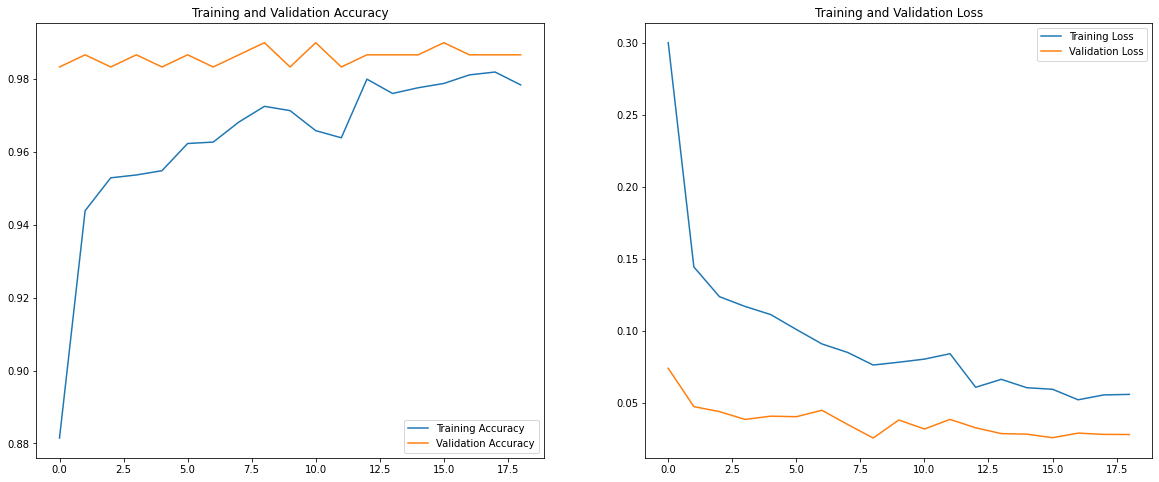

In [92]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(19)

plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [182]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = 1,
    shuffle = False,
    seed = 123)

test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

Found 300 files belonging to 3 classes.


In [183]:
# Generate predictions
model2.load_weights('/project/code/deepak/Pytorch_Tutorial/vgg16_best_weights_fine_tuning.hdf5') # initialize the best trained weights
preds = model2.predict(test_ds)
pred_classes = np.argmax(preds, axis = 1)

In [184]:
model2.evaluate(test_ds, verbose = 1)

300/300 [==============================] - 2s 8ms/step - loss: 0.0256 - accuracy: 0.9900


[0.025564491748809814, 0.9900000095367432]

# **Concludes**

**Accuracy On Transfer Learning : 98.6%** </br>
**Accuracy On Fine Tuning : 99%**</br>


In [186]:
class_names = train_ds.class_names
n_classes = len(class_names)
print(class_names)

['cats', 'dogs', 'panda']


In [187]:
# list of number of images belonging to each class in test directory
test_images = []

for label in class_names:
    dir_name = test_data_dir + label
    test_images.append(len([name for name in os.listdir(dir_name)]))
test_images

[100, 100, 100]

In [192]:
# targets list
targets = []
for i in range(0, len(test_images)):
    targets += [i]*test_images[i]
true_classes = np.asarray(targets)
#test_images, class_names, true_classes

In [189]:
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(true_classes, pred_classes, target_names = class_names))

              precision    recall  f1-score   support

        cats       1.00      0.98      0.99       100
        dogs       0.97      1.00      0.99       100
       panda       1.00      0.99      0.99       100

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



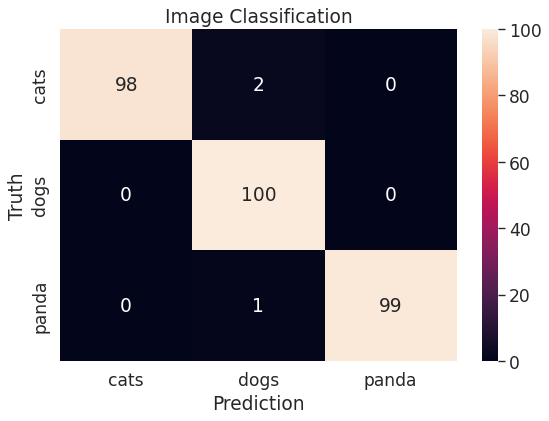

In [191]:


def plot_confusion_matrix(test_labels, pred_labels, CLASSES):
    conf_arr = confusion_matrix(test_labels, pred_labels)

    plt.figure(figsize = (8, 5.5), dpi = 80, facecolor = 'w', edgecolor = 'k')
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(conf_arr, annot = True, fmt = '', xticklabels = CLASSES, yticklabels = CLASSES)

    plt.title('Image Classification')
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.show(ax)

plot_confusion_matrix(true_classes, pred_classes, class_names)

In [194]:
from sklearn.metrics import roc_curve, roc_auc_score

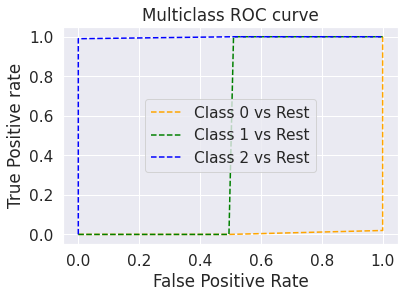

In [196]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(true_classes, pred_classes, pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);